In [19]:
# %%
# ==============================================================
# 1. Imports & notebook settings (CIB 225 GHz – MJy/sr)
# ==============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

%matplotlib inline
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "font.family": "DejaVu Sans",
    "text.usetex": False,           # <-- Keep False
    "mathtext.fontset": "dejavusans"})  # or "cm", "stix"})

# ------------------------------------------------------------------
# USER SETTINGS (CIB ν=225 GHz)
# ------------------------------------------------------------------
FITS_NAME = "cib_nu0225.fits"
BASE_DIR  = os.path.expanduser("~/Desktop/Project2/Plots/WebSky_Maps")
FITS_FILE = os.path.join(BASE_DIR, FITS_NAME)

OUT_DIR = os.path.join(BASE_DIR, "output_WebSky_CIB_225")
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Output will be saved to: {OUT_DIR}")

Output will be saved to: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225


In [2]:
# %%
# ==============================================================
# 2. Load CIB ν=225 GHz map (units: MJy/sr)
# ==============================================================

def load_cib_map():
    print("\n" + "="*70)
    print("LOADING CIB ν=225 GHz MAP")
    print("="*70)
    
    with fits.open(FITS_FILE) as hdul:
        hdr = hdul[1].header
        col_name = hdul[1].data.columns.names[0]
        data = hdul[1].data[col_name].flatten()
        
        nside = hp.npix2nside(len(data))
        ordering = hdr.get('ORDERING', 'RING').strip().upper()
        units = hdr.get('TUNIT1', 'MJy/sr').strip()  # Corrected default
        freq_ghz = hdr.get('FREQ', 225)
        
        print(f"Column: {col_name}")
        print(f"NSIDE: {nside} → NPIX: {len(data)}")
        print(f"ORDERING: {ordering}")
        print(f"Units: {units}")
        print(f"Frequency: {freq_ghz} GHz")
        
        return data, hdr, col_name, ordering, nside, units

if not os.path.isfile(FITS_FILE):
    raise FileNotFoundError(f"Cannot find {FITS_FILE}")

data, hdr, col_name, ordering, nside, units = load_cib_map()


LOADING CIB ν=225 GHz MAP
Column: T
NSIDE: 4096 → NPIX: 201326592
ORDERING: RING
Units: MJy/sr
Frequency: 225 GHz


In [3]:
# %%
# ==============================================================
# 3. Pixel statistics (MJy/sr)
# ==============================================================

def print_pixel_stats(data):
    print("\n" + "="*70)
    print(f"PIXEL STATISTICS ({units})")
    print("="*70)
    
    stats = {
        'min':    np.min(data),
        'max':    np.max(data),
        'mean':   np.mean(data),
        'std':    np.std(data),
        'rms':    np.sqrt(np.mean(data**2)),
        'median': np.median(data),
        '99th %': np.percentile(data, 99),
        '1st %':  np.percentile(data, 1)
    }
    
    for key, val in stats.items():
        print(f"  {key:8s}: {val: .6e}")
    
    return stats

stats = print_pixel_stats(data)


PIXEL STATISTICS (MJy/sr)
  min     :  0.000000e+00
  max     :  7.772492e+01
  mean    :  3.548260e-02
  std     :  2.430732e-02
  rms     :  4.301007e-02
  median  :  3.251867e-02
  99th %  :  9.464631e-02
  1st %   :  2.576298e-03


<Figure size 1600x800 with 0 Axes>

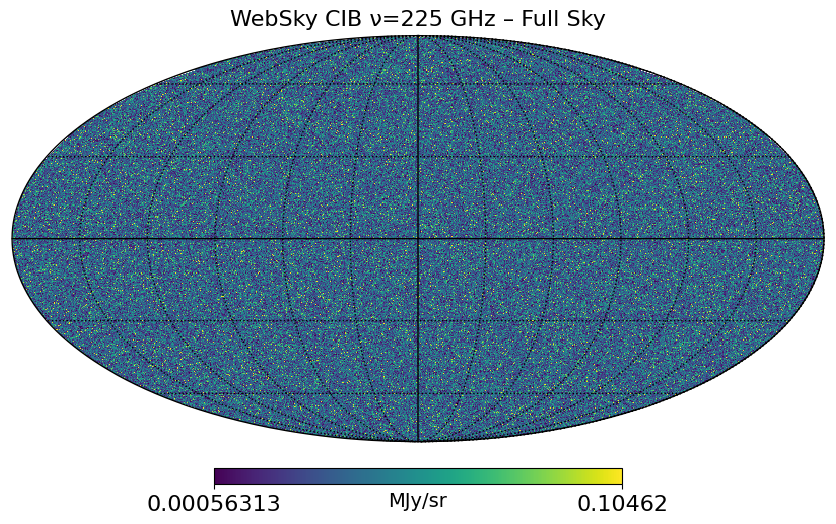

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cib_225_mollweide.pdf


In [20]:
# %%
# ==============================================================
# 4. Mollweide full-sky map
# ==============================================================

vmin, vmax = np.percentile(data, [0.5, 99.5])

plt.figure(figsize=(16, 8))
hp.mollview(
    data,
    title='WebSky CIB ν=225 GHz – Full Sky',
    unit=units,
    cmap='viridis',
    min=vmin, max=vmax,
    nest=(ordering == 'NESTED')
)
hp.graticule()
ax = plt.gca()
ax.title.set_fontsize(16)

moll_path = os.path.join(OUT_DIR, "cib_225_mollweide.pdf")
plt.savefig(moll_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {moll_path}")


Generating pixel-value histogram...


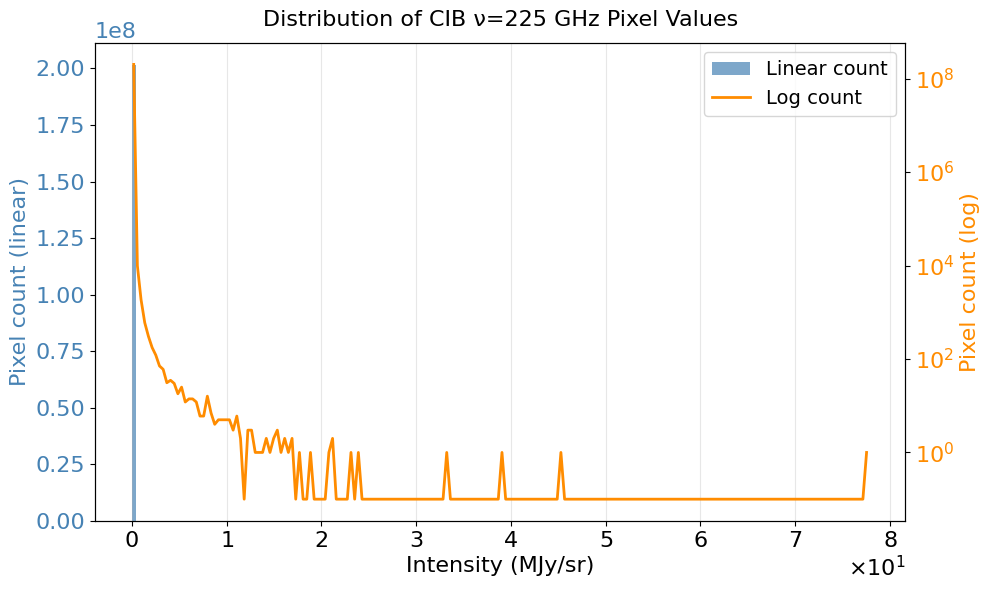

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cib_225_histogram.pdf
Saved histogram data: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cib_225_histogram_data.txt


In [22]:
# %%
# ==============================================================
# 5. Histogram of pixel values – dual linear/log (MJy/sr)
# ==============================================================

print("\nGenerating pixel-value histogram...")

values = data.flatten()
values = values[np.isfinite(values)]

n_bins = 200
counts, bin_edges = np.histogram(values, bins=n_bins, density=False)

# Offset zeros for log scale
counts_log = counts.astype(float)
counts_log[counts_log == 0] = np.min(counts_log[counts_log > 0]) * 0.1

# ----- Plot -----
fig, ax = plt.subplots(figsize=(10, 6))
ax_hist = ax
ax_log  = ax.twinx()

# Linear histogram (filled)
ax_hist.bar(bin_edges[:-1], counts, width=np.diff(bin_edges),
            color='steelblue', alpha=0.7, label='Linear count', align='edge')
ax_hist.set_yscale('linear')
ax_hist.set_ylabel('Pixel count (linear)', color='steelblue', fontsize=16)
ax_hist.tick_params(axis='y', labelcolor='steelblue')

# Log histogram (line)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax_log.plot(bin_centers, counts_log, color='darkorange', linewidth=2, label='Log count')
ax_log.set_yscale('log')
ax_log.set_ylabel('Pixel count (log)', color='darkorange', fontsize=16)
ax_log.tick_params(axis='y', labelcolor='darkorange')

# X-axis: compact scientific notation
ax_hist.set_xlabel(f'Intensity ({units})', fontsize=16)
ax_hist.xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
ax_hist.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useOffset=False)

# Title & grid
ax_hist.set_title('Distribution of CIB ν=225 GHz Pixel Values', fontsize=16, pad=12)
ax_hist.grid(True, which='major', alpha=0.3, axis='x')

# Combined legend
lines1, labels1 = ax_hist.get_legend_handles_labels()
lines2, labels2 = ax_log.get_legend_handles_labels()
ax_hist.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)

plt.tight_layout()

hist_path = os.path.join(OUT_DIR, "cib_225_histogram.pdf")
plt.savefig(hist_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {hist_path}")

# Save data
hist_data_path = os.path.join(OUT_DIR, "cib_225_histogram_data.txt")
np.savetxt(hist_data_path, np.column_stack([bin_centers, counts]),
           header='bin_center pixel_count', fmt='%.6e')
print(f"Saved histogram data: {hist_data_path}")


Computing (or loading cached) power spectrum...
  -> Loading cached C_ℓ from /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cache/cib_225_powerspectrum_cl.pkl


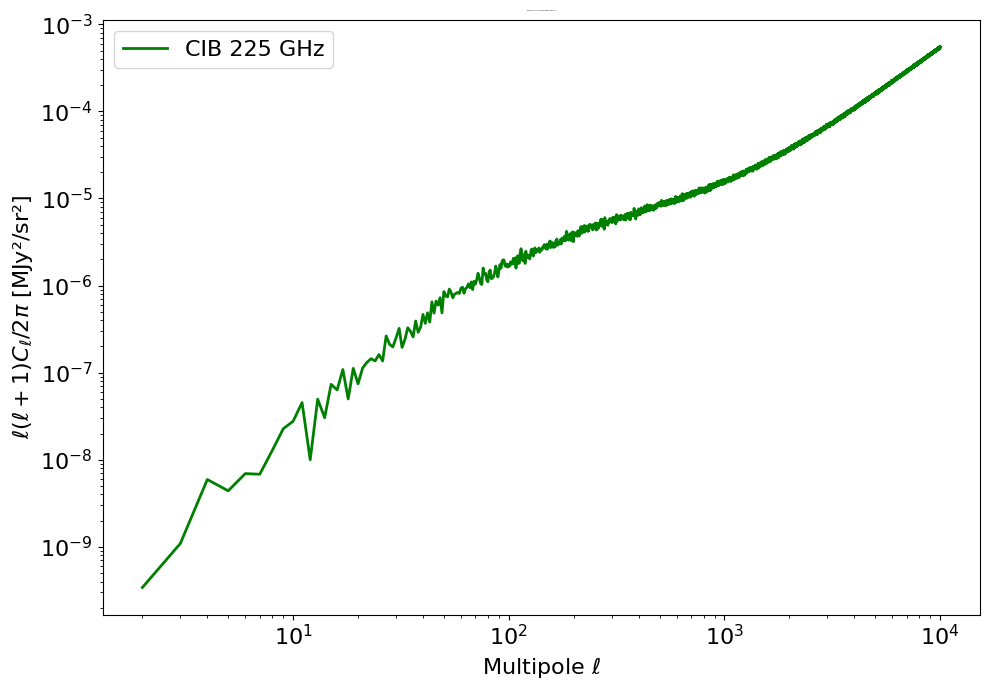

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cib_225_powerspectrum.pdf


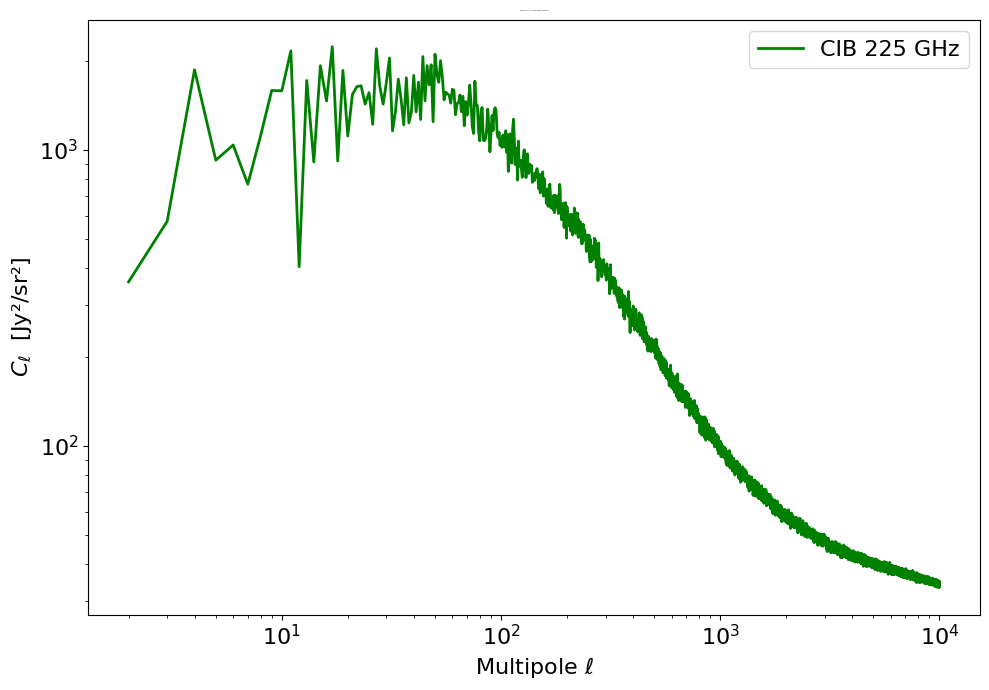

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cib_225_Cls.pdf
Saved data: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_WebSky_CIB_225/cib_225_powerspectrum_data.txt


In [30]:
# %%
# ==============================================================
# 6. Power spectrum (with caching + toggle)
# ==============================================================

import pickle
from pathlib import Path

cache_dir = Path(OUT_DIR) / "cache"
cache_dir.mkdir(exist_ok=True)
cache_file = cache_dir / "cib_225_powerspectrum_cl.pkl"

# TOGGLE: Set to True to force recompute
force_recalculate = False

print("\nComputing (or loading cached) power spectrum...")

if force_recalculate or not cache_file.exists():
    print(f"  -> Computing C_ℓ (lmax ≤ 10000)...")
    map_ring = data if ordering == 'RING' else hp.reorder(data, n2r=True)
    lmax = min(3*nside - 1, 10000)
    cl = hp.anafast(map_ring, lmax=lmax)
    ell = np.arange(len(cl))
    
    print(f"  -> Saving C_ℓ to cache: {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump(cl, f)
else:
    print(f"  -> Loading cached C_ℓ from {cache_file}")
    with open(cache_file, 'rb') as f:
        cl = pickle.load(f)
    ell = np.arange(len(cl))

Dl = ell * (ell + 1) * cl / (2 * np.pi)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(ell[2:], Dl[2:], 'g-', lw=2, label='CIB 225 GHz')  # No 1e12 scaling for MJy/sr
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(10, 10000)
#ax.set_ylim(1e-6, 1e2)  # Relaxed for MJy²/sr²
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$\ell(\ell+1) C_\ell / 2\pi$ [MJy²/sr²]')
ax.set_title('WebSky CIB ν=225 GHz Power Spectrum')
#ax.grid(True, which='both', alpha=0.3)
ax.legend()

plt.tight_layout()
ps_path = os.path.join(OUT_DIR, "cib_225_powerspectrum.pdf")
plt.savefig(ps_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {ps_path}")

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(ell[2:], cl[2:]*1e12, 'g-', lw=2, label='CIB 225 GHz')  # No 1e12 scaling for MJy/sr
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(10, 10000)
#ax.set_ylim(1e-6, 1e2)  # Relaxed for MJy²/sr²
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$  [Jy²/sr²]')
ax.set_title('WebSky CIB ν=225 GHz Power Spectrum')
#ax.grid(True, which='both', alpha=0.3)
ax.legend()

plt.tight_layout()
ps_path = os.path.join(OUT_DIR, "cib_225_Cls.pdf")
plt.savefig(ps_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {ps_path}")

txt_path = os.path.join(OUT_DIR, "cib_225_powerspectrum_data.txt")
np.savetxt(txt_path, np.column_stack([ell, cl, Dl]),
           header='ell  C_ell  D_ell', fmt='%.6e')
print(f"Saved data: {txt_path}")